## Orientation feature tracking hybrid - evaluation
We do limbus detection using Hough transform, where we obtain translation and scale. We manually pick the zeroth degree in initial frame. Then features are detected and rotation is estimated relative to the first frame.

### 1. Imports

In [1]:
import cv2
import numpy as np
import copy
from matplotlib import pyplot as plt
from helpers.limbus_detection import detect_circle
from helpers.orientation_detection_hybrid import estimate_orientation_hybrid, transform_2d_matmul, get_transform_info

%load_ext autoreload
%autoreload 2

### 2. Evaluation on images

In [60]:
MAX_DIM_DEFAULT = 640
LIMBUS_RADIUS_INFLATION = 1.2
# KD_INIT = lambda: cv2.SIFT_create(contrastThreshold=0.01)
# MATCHER_INIT = lambda: cv2.BFMatcher_create(normType=cv2.NORM_L2)
KD_INIT = lambda: cv2.BRISK_create()
MATCHER_INIT = lambda: cv2.BFMatcher_create(normType=cv2.NORM_HAMMING)
# KD_INIT = lambda: cv2.ORB_create()
# MATCHER_INIT = lambda: cv2.BFMatcher_create(normType=cv2.NORM_HAMMING)

In [61]:
def evaluate_images(images, limbus_circles, kd, matcher):
    images_count = len(images)
    
    images_values = [cv2.cvtColor(i, cv2.COLOR_BGR2HSV)[:,:,2] for i in images]
    images_vis = [cv2.cvtColor(i, cv2.COLOR_GRAY2BGR) for i in images_values]
    images_masks = []
    
    # masking
    for i in range(images_count):
        limbus_circle = limbus_circles[i]
        mask = np.zeros_like(images_values[i])
        mask = cv2.circle(mask, (round(limbus_circle[0]), round(limbus_circle[1])), round(
                limbus_circle[2]*LIMBUS_RADIUS_INFLATION), 255, thickness=-1, lineType=cv2.LINE_AA)

        images_masks.append(mask)
    
    # orientation detection
    images_keypoints = []
    images_descriptors = []
    rotations = []
    transform_rotations = []
    transform_no_rotations = []
    goods = []
    
    for i in range(images_count):
        # keypoints, descriptors
        keypoints, descriptors = kd.detectAndCompute(images_values[i], mask=images_masks[i])
        images_keypoints.append(keypoints)
        images_descriptors.append(descriptors)
        
    for i in range(images_count):
        # rotation, transform_rotation, transform_no_rotation
        rotation, transform_rotation, transform_no_rotation = estimate_orientation_hybrid(
            images_keypoints[0], images_descriptors[0], limbus_circles[0],
            images_keypoints[i], images_descriptors[i], limbus_circles[i],
            verbose=True
        )
        rotations.append(rotation)
        transform_rotations.append(transform_rotation)
        transform_no_rotations.append(transform_no_rotation)
        
        # good
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(images_descriptors[0], images_descriptors[i], k=2)

        # ratio test
        good = []
        for m, n in matches:
            if m.distance < 0.75*n.distance:
                good.append([m])
                
        goods.append(good)
    
    # visualization
    fig, plots = plt.subplots(5, images_count, figsize=(10,10*3))
    
    # limbus detections
    for i in range(images_count):
        vis = images_vis[i].copy()
        limbus_circle = limbus_circles[i]
        cv2.circle(vis, (round(limbus_circle[0]), round(limbus_circle[1])), round(
            limbus_circle[2]), (0, 255, 0), thickness=3, lineType=cv2.LINE_AA)
        
        plots[0][i].set_title(f'limbus detection ({i})')
        plots[0][i].imshow(vis)
        plots[0][i].axis('off')
        
    # matches
    for i in range(images_count):
        vis = cv2.drawMatchesKnn(
            images_values[0], images_keypoints[0], 
            images_values[i], images_keypoints[i], 
            goods[i], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
        plots[1][i].set_title(f'matches (0x{i}): {len(goods[i])} in total')
        plots[1][i].imshow(vis)
        plots[1][i].axis('off')
        
    # warp & diff
    for i in range(images_count):
        get_transform_info(transform_rotations[i], verbose=True)
        vis = cv2.warpAffine(
            images_vis[0],
            transform_2d_matmul(transform_rotations[i], transform_no_rotations[i]),
            (images_vis[i].shape[1], images_vis[i].shape[0]))
        
        plots[2][i].set_title(f'warp (0->{i})')
        plots[2][i].imshow(vis)
        plots[2][i].axis('off')
        
        diff = cv2.normalize(images_vis[i] - vis, None,
                     alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        
        plots[3][i].set_title(f'diff (0->{i})')
        plots[3][i].imshow(diff)
        plots[3][i].axis('off')
        
    # axis
    for i in range(images_count):
        vis = images_vis[i].copy()
        rad = np.pi * rotations[i] / 180
        start = (
            round(limbus_circles[i][0] + limbus_circles[i][2]*np.cos(rad)),
            round(limbus_circles[i][1] + limbus_circles[i][2]*np.sin(rad)),
        )
        end = (
            round(limbus_circles[i][0] - limbus_circles[i][2]*np.cos(rad)),
            round(limbus_circles[i][1] - limbus_circles[i][2]*np.sin(rad)),
        )
        cv2.line(vis, start, end, (0,255,0), thickness=3, lineType=cv2.LINE_AA)
        
        plots[4][i].set_title(f'axis ({i})')
        plots[4][i].imshow(vis)
        plots[4][i].axis('off')
        
    fig.tight_layout()      
    plt.show()

#### 2.1 Rhexis augmented

translation (px): [0. 0.], rotation angle (deg): 0.0, scale: 1.0
translation (px): [254.7114409  -37.23160432], rotation angle (deg): 40.80779393959465, scale: 0.9992302283274634
translation (px): [526.67009706 155.93486661], rotation angle (deg): 94.7428113376143, scale: 1.0031414018834317


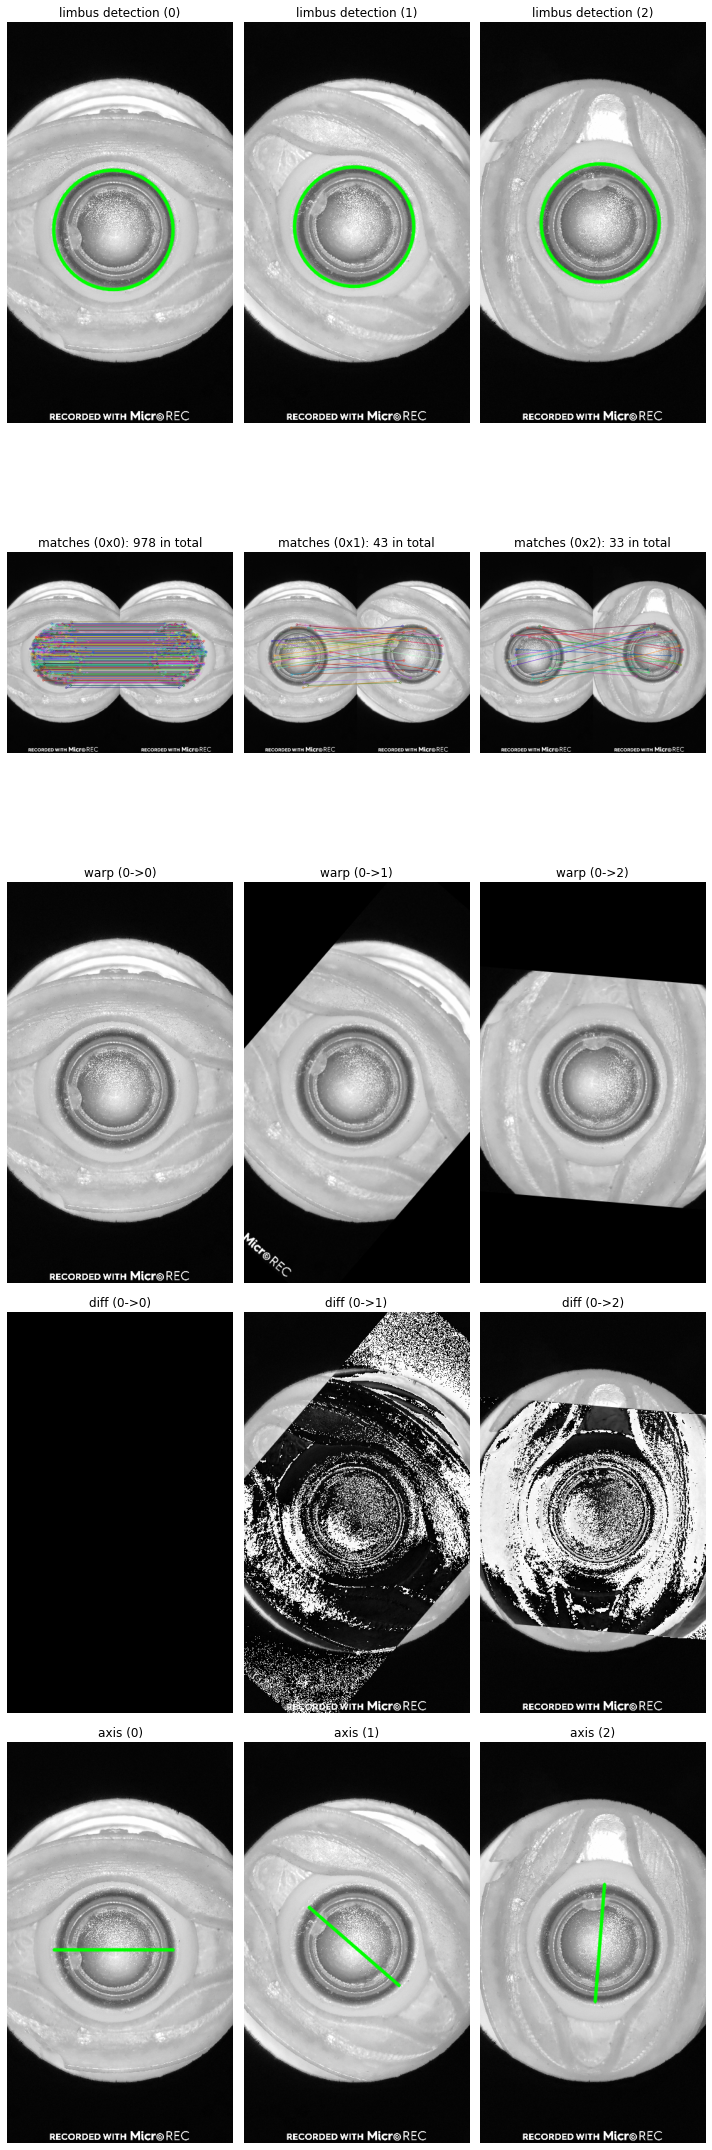

In [62]:
# loading and preprocessing
images_paths = [
    'data/artificial/rhexis_augmented_rotation1.jpg',
    'data/artificial/rhexis_augmented_rotation2.jpg',
    'data/artificial/rhexis_augmented_rotation3.jpg'
]
images = [
    cv2.imread(path)
    for path in images_paths
]

for i in range(len(images)):
    scale = MAX_DIM_DEFAULT / max(images[i].shape)
    images[i] = cv2.resize(images[i], (0,0), fx=scale, fy=scale)

limbus_circles = []
for i in range(len(images)):
    limbus_circle = detect_circle(
        cv2.cvtColor(images[i], cv2.COLOR_BGR2HSV)[:,:,2],
        validation='inout',
        validation_mode='max',
        validation_value_thresh=0.0,
        considered_ratio_s=1.0,
        circle_width_to_radius_ratio=0.1,
        min_radius_ratio=1/10,
        max_radius_ratio=1/2,
        max_processing_dim=240,
        gaussian_blur_sigma=3.0
    )
    limbus_circles.append(limbus_circle)

evaluate_images(images, limbus_circles, kd=KD_INIT(), matcher=MATCHER_INIT())

#### 2.2 Bioniko

translation (px): [0. 0.], rotation angle (deg): 0.0, scale: 1.0
translation (px): [-140.12402328  108.03105855], rotation angle (deg): -27.535710225465685, scale: 1.0293163093487936
translation (px): [-196.11309369  245.42045909], rotation angle (deg): -49.41565865004633, scale: 1.005209598956085
translation (px): [-172.41804889  459.75842854], rotation angle (deg): -83.42877983172707, scale: 1.0205579136893133
translation (px): [-13.79047185 481.10072339], rotation angle (deg): -95.0365852729362, scale: 0.660326959288429


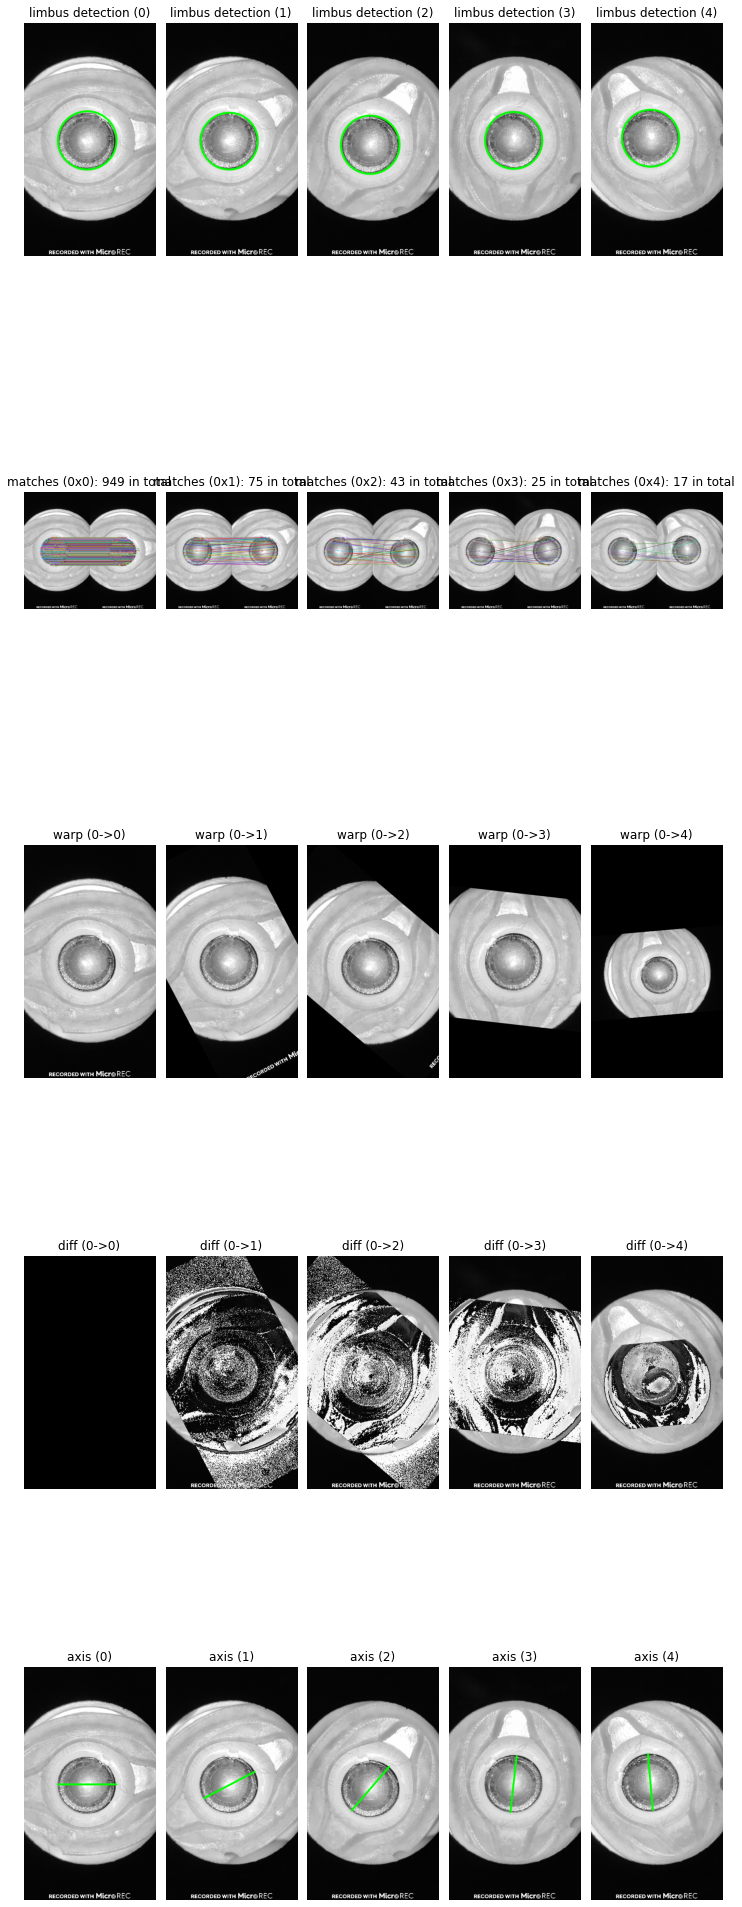

In [63]:
# loading and preprocessing
images_paths = [
    'data/artificial/bioniko_rotation1.jpg',
    'data/artificial/bioniko_rotation2.jpg',
    'data/artificial/bioniko_rotation3.jpg',
    'data/artificial/bioniko_rotation4.jpg',
    'data/artificial/bioniko_rotation5.jpg',
]
images = [
    cv2.imread(path)
    for path in images_paths
]

for i in range(len(images)):
    scale = MAX_DIM_DEFAULT / max(images[i].shape)
    images[i] = cv2.resize(images[i], (0,0), fx=scale, fy=scale)

limbus_circles = []
for i in range(len(images)):
    limbus_circle = detect_circle(
        cv2.cvtColor(images[i], cv2.COLOR_BGR2HSV)[:,:,2],
        validation='inout',
        validation_mode='max',
    )
    limbus_circles.append(limbus_circle)

evaluate_images(images, limbus_circles, kd=KD_INIT(), matcher=MATCHER_INIT())

#### 2.3 Bioniko augmented

translation (px): [0. 0.], rotation angle (deg): 0.0, scale: 1.0
translation (px): [-146.67632794  141.78159666], rotation angle (deg): -33.892146277070374, scale: 0.991126924252781
translation (px): [-200.19549086  295.01731076], rotation angle (deg): -59.75341752998669, scale: 0.9984587585165626
translation (px): [-152.34021931  476.33671381], rotation angle (deg): -87.8568484978997, scale: 0.9857903869426246


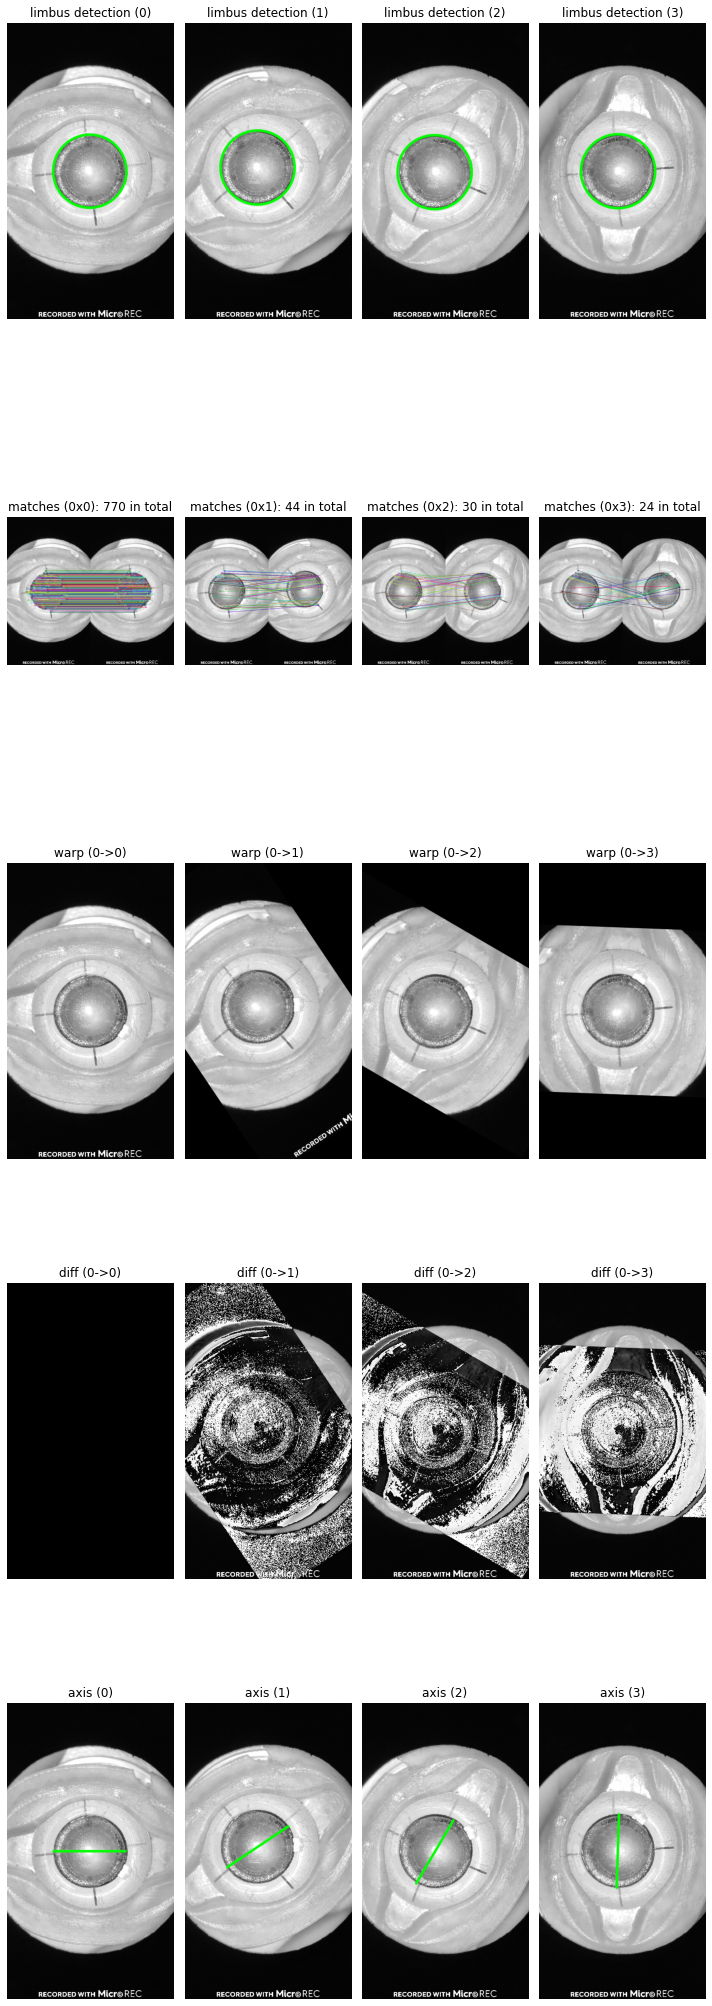

In [64]:
# loading and preprocessing
images_paths = [
    'data/artificial/bioniko_augmented_rotation1.jpg',
    'data/artificial/bioniko_augmented_rotation2.jpg',
    'data/artificial/bioniko_augmented_rotation3.jpg',
    'data/artificial/bioniko_augmented_rotation4.jpg',
]
images = [
    cv2.imread(path)
    for path in images_paths
]

for i in range(len(images)):
    scale = MAX_DIM_DEFAULT / max(images[i].shape)
    images[i] = cv2.resize(images[i], (0,0), fx=scale, fy=scale)

limbus_circles = []
for i in range(len(images)):
    limbus_circle = detect_circle(
        cv2.cvtColor(images[i], cv2.COLOR_BGR2HSV)[:,:,2],
        validation='inout',
        validation_mode='max',
    )
    limbus_circles.append(limbus_circle)

evaluate_images(images, limbus_circles, kd=KD_INIT(), matcher=MATCHER_INIT())

### 3. Evaluation on videos